<a href="https://colab.research.google.com/github/heldigard/deeplearning-eval/blob/main/Image_Classification_VGG16_ResNet50_InceptionV3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Taller Deep Learning: Image Classification con Modelos Pre-entrenados**

**Integrantes**
* Eldigardo Camacho

Se va a utilizar la base de datos de **Natural Scene**, Estos son datos de imágenes de escenas naturales de todo el mundo. Las imágenes se han recopilado de la web y etiquetado manualmente. Las imágenes están divididas en 6 categorías. Estas son las categorías:
1. Buildings
2. Forest
3. Glacier
4. Mountain
5. Sea
6. Street 

Hay alrededor de 14k imágenes en Train, 3k en Test y 7k en Prediction.
En este cuaderno, se usa el proceso de implementación de CNN con Keras para clasificar imágenes.

Se utilizaran los modelos VGG16, ResNet50 e InceptionV3 para realizar la clasificación de las imágenes. Y de estos escoger el que mejor desempeño tenga.

Enlace de datos:
[Descargar la base de datos aquí]('https://www.kaggle.com/datasets/puneet6060/intel-image-classification/data')

## **1. Cargar las librerias necesarias**

In [1]:
# Importar las librerias necesarias
import numpy as np
import os
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
from tqdm import tqdm
from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd
from tensorflow.keras.applications import VGG16, ResNet50, InceptionV3
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

## **2. Cargar los datos**

In [2]:
# Definir el tamaño de las imágenes
IMAGE_SIZE = (150, 150)

# Creando las etiquetas correspondientes a las categorias
nombres_clases = ["mountain", "street", "glacier", "buildings", "sea", "forest"]
etiquetas_clases = {nombre_clase: i for i, nombre_clase in enumerate(nombres_clases)}
etiquetas_clases

{'mountain': 0,
 'street': 1,
 'glacier': 2,
 'buildings': 3,
 'sea': 4,
 'forest': 5}

### **2.1 Cargar las imágenes**

In [3]:
def cargar_datos():
    """
    Cargar los datos:
        - 14,034 imágenes para entrenar la red.
        - 3,000 imágenes para evaluar la precisión con la que la red clasifica las imágenes.
    """

    datasets = ["./seg_train", "./seg_test"]
    salida = []

    # Iterar a través de los conjuntos de entrenamiento y prueba
    for dataset in datasets:

        imagenes = []
        etiquetas = []

        print(f"Cargando {dataset}")

        # Iterar a través de cada carpeta correspondiente a una categoría
        for carpeta in os.listdir(dataset):
            etiqueta = etiquetas_clases[carpeta]

            # Iterar a través de cada imagen en nuestra carpeta
            for archivo in tqdm(os.listdir(os.path.join(dataset, carpeta))):

                # Obtener la ruta de la imagen
                ruta_img = os.path.join(os.path.join(dataset, carpeta), archivo)

                # Abrir y redimensionar la imagen
                imagen = cv2.imread(ruta_img)
                imagen = cv2.cvtColor(imagen, cv2.COLOR_BGR2RGB)
                imagen = cv2.resize(imagen, IMAGE_SIZE)

                # Añadir la imagen y su etiqueta correspondiente a la salida
                imagenes.append(imagen)
                etiquetas.append(etiqueta)

        imagenes = np.array(imagenes, dtype="float32")
        etiquetas = np.array(etiquetas, dtype="int32")

        salida.append((imagenes, etiquetas))

    return salida

In [4]:
# Cargar los datos
(train_images, train_labels), (test_images, test_labels) = cargar_datos()

Cargando ./seg_train


100%|██████████| 2382/2382 [00:00<00:00, 3225.27it/s]


Cargando ./seg_test


100%|██████████| 501/501 [00:00<00:00, 3238.69it/s]


## **3. Normalización de los datos**
Normalizar los datos para mejorar el rendimiento de la red. Para que queden en la escala de 0 a 1.

In [5]:
# Normalizar las imágenes
train_images = train_images / 255.0
test_images = test_images / 255.0

In [6]:
# Mezclar aleatoriamente los datos de entrenamiento
train_images, train_labels = shuffle(train_images, train_labels, random_state=25)

## **4. Visualización de los datos**

In [7]:
n_train = train_labels.shape[0]
n_test = test_labels.shape[0]

print ("Imagenes de entrenamiento: {}".format(n_train))
print ("Imagenes de prueba: {}".format(n_test))
print ("Cada imagen es de tamaño: {}".format(IMAGE_SIZE))

Imagenes de entrenamiento: 14034
Imagenes de prueba: 3000
Cada imagen es de tamaño: (150, 150)


### **3.1 Visualización de Dataset**
Revisamos que tan distribuidas están las imágenes en cada carpeta.

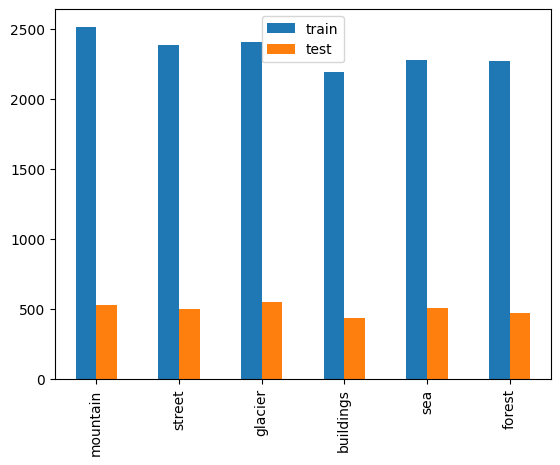

In [8]:
_, train_counts = np.unique(train_labels, return_counts=True)
_, test_counts = np.unique(test_labels, return_counts=True)
pd.DataFrame(
    {'train': train_counts, 'test': test_counts},
    index=nombres_clases
    ).plot.bar()
plt.show()

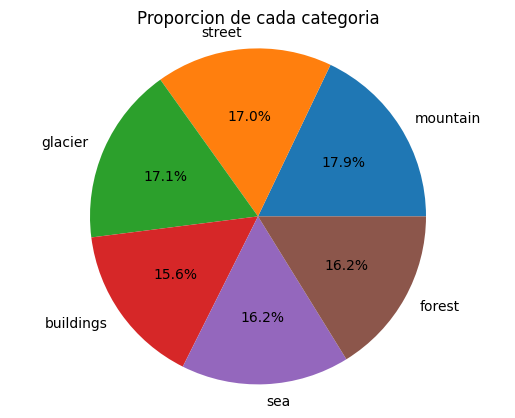

In [9]:
plt.pie(train_counts,
        explode=(0, 0, 0, 0, 0, 0) ,
        labels=nombres_clases,
        autopct='%1.1f%%')
plt.axis('equal')
plt.title('Proporcion de cada categoria')
plt.show()

Vemos que las imagenes en cada categoria esta bastante balanceadas. Sin embargo, las imagenes de buildings son las que menos tenemos. Esto puede ser un problema, ya que la red podría aprender mal a clasificar las imagenes de buildings. Para solucionar esto, podemos aumentar el numero de imagenes de buildings usando data augmentation. Sin embargo, en este caso, no lo haremos.

## **5. Visualización de imagenes**

In [10]:
def mostrar_imagen_aleatoria(nombres_clases, images, labels):
    """
        Muestra una imagen aleatoria del arreglo de imágenes y su etiqueta correspondiente del arreglo de etiquetas.
    """
    index = np.random.randint(images.shape[0])
    plt.figure()
    plt.imshow(images[index])
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.title('Imagen #{} : '.format(index) + nombres_clases[labels[index]])
    plt.show()

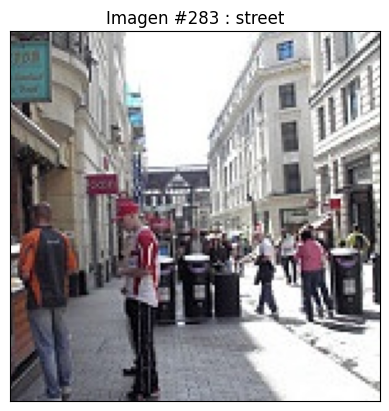

In [11]:
mostrar_imagen_aleatoria(nombres_clases, train_images, train_labels)

También podemos mostrar las primeras 25 imágenes del conjunto de entrenamiento directamente con un bucle para obtener una mejor vista previa.

In [12]:
def mostrar_ejemplos(nombres_clases, imagenes, etiquetas):
    """
        Muestra 25 imágenes de las imágenes con sus correspondientes etiquetas
    """

    fig = plt.figure(figsize=(10,10))
    fig.suptitle("Algunos ejemplos de imágenes del conjunto de datos", fontsize=16)
    for i in range(25):
        plt.subplot(5,5,i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(imagenes[i], cmap=plt.cm.binary)
        plt.xlabel(nombres_clases[etiquetas[i]])
    plt.show()


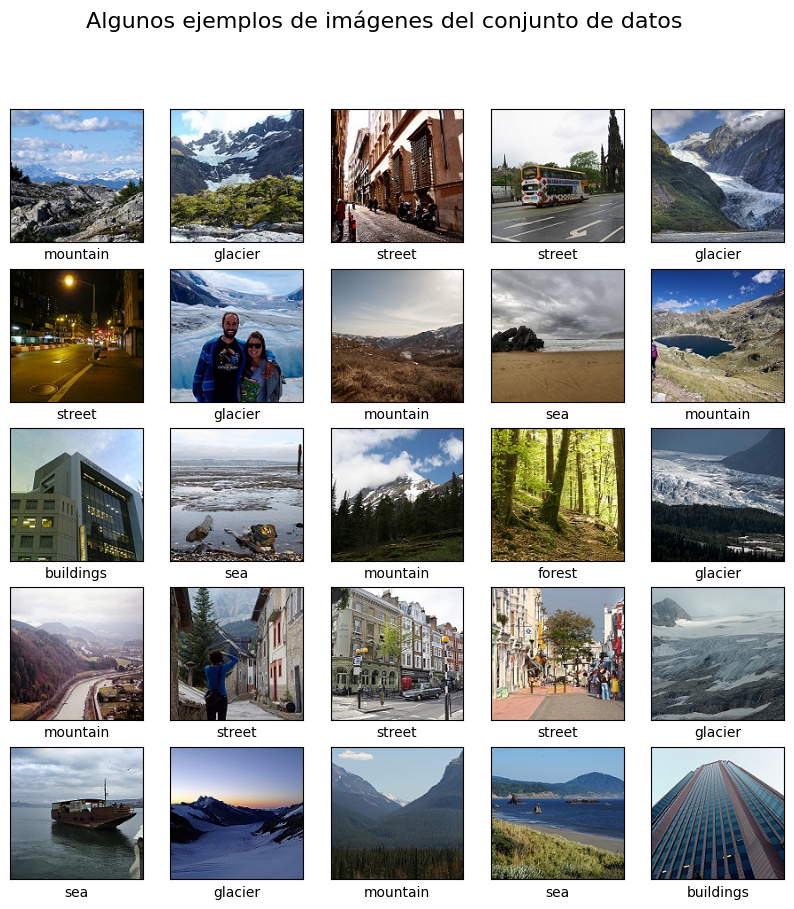

In [13]:
mostrar_ejemplos(nombres_clases, train_images, train_labels)

# B. Cargar los modelos VGG16, ResNet50 y InceptionV3

In [14]:
# Crear los modelos preentrenados
base_model_VGG16 = VGG16(weights='imagenet', include_top=False, input_shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3))
base_model_ResNet50 = ResNet50(weights='imagenet', include_top=False, input_shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3))
base_model_InceptionV3 = InceptionV3(weights='imagenet', include_top=False, input_shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3))


# B.1. Congelar los modelos

In [15]:
# Congelar las capas base
for layer in base_model_VGG16.layers:
    layer.trainable = False

for layer in base_model_ResNet50.layers:
    layer.trainable = False

for layer in base_model_InceptionV3.layers:
    layer.trainable = False

# B.2. Crear la red en cada uno de los modelos

In [16]:
# Agregar capas adicionales para la clasificación
x_VGG16 = base_model_VGG16.output
x_VGG16 = Flatten()(x_VGG16)
x_VGG16 = Dense(64, activation='relu')(x_VGG16)
x_VGG16 = Dense(6, activation='softmax')(x_VGG16)
model_VGG16 = Model(inputs=base_model_VGG16.input, outputs=x_VGG16)

In [17]:
x_ResNet50 = base_model_ResNet50.output
x_ResNet50 = Flatten()(x_ResNet50)
x_ResNet50 = Dense(64, activation='relu')(x_ResNet50)
x_ResNet50 = Dense(6, activation='softmax')(x_ResNet50)
model_ResNet50 = Model(inputs=base_model_ResNet50.input, outputs=x_ResNet50)

In [18]:
x_InceptionV3 = base_model_InceptionV3.output
x_InceptionV3 = Flatten()(x_InceptionV3)
x_InceptionV3 = Dense(64, activation='relu')(x_InceptionV3)
x_InceptionV3 = Dense(6, activation='softmax')(x_InceptionV3)
model_InceptionV3 = Model(inputs=base_model_InceptionV3.input, outputs=x_InceptionV3)

# B.3. Compilar los modelos

In [19]:
# Compilar los modelos
model_VGG16.compile(optimizer=Adam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model_ResNet50.compile(optimizer=Adam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model_InceptionV3.compile(optimizer=Adam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])


# B.4. Entrenar los modelos

In [20]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import os

# Callback para detener el entrenamiento temprano si no hay mejora en la pérdida de validación
early_stopping = EarlyStopping(
    monitor="val_loss", patience=5, restore_best_weights=True
)


# Función auxiliar para generar el nombre del archivo con las métricas y prefijo del modelo
def create_model_checkpoint_path(epoch, logs, model_name):
    val_loss = logs["val_loss"]
    val_accuracy = logs["val_accuracy"]
    return os.path.join(
        save_dir,
        f"{model_name}_epoch_{epoch:02d}_val_loss_{val_loss:.2f}_val_accuracy_{val_accuracy:.2f}.keras",
    )


# Directorio donde se guardarán los modelos
save_dir = "model_checkpoints"
os.makedirs(save_dir, exist_ok=True)


class CustomModelCheckpoint(ModelCheckpoint):
    def __init__(self, filepath, model_name, *args, **kwargs):
        super(CustomModelCheckpoint, self).__init__(filepath, *args, **kwargs)
        self.model_name = model_name

    def on_epoch_end(self, epoch, logs=None):
        # Generamos el nuevo nombre del archivo con la función create_model_checkpoint_path
        new_filepath = create_model_checkpoint_path(epoch, logs, self.model_name)

        # Actualizamos nuestra propiedad filepath para que se use este nuevo nombre de archivo.
        self.filepath = new_filepath

        # Guardamos el modelo con el nuevo filepath
        self.model.save(self.filepath)


# Instancia del callback personalizado
def get_custom_model_checkpoint(model_name):
    return CustomModelCheckpoint(
        filepath=os.path.join(save_dir, f"{model_name}_best_model.keras"),
        model_name=model_name,
        monitor="val_loss",
        save_best_only=True,
    )

In [21]:
# Entrenar los modelos
history_VGG16 = model_VGG16.fit(
    train_images,
    train_labels,
    epochs=7,
    batch_size=32,
    validation_data=(test_images, test_labels),
    callbacks=[early_stopping, get_custom_model_checkpoint("VGG16")],
)

Epoch 1/7
439/439 ━━━━━━━━━━━━━━━━━━━━ 232s 527ms/step - accuracy: 0.7787 - loss: 0.5800 - val_accuracy: 0.8703 - val_loss: 0.3480
Epoch 2/7
439/439 ━━━━━━━━━━━━━━━━━━━━ 229s 523ms/step - accuracy: 0.9045 - loss: 0.2634 - val_accuracy: 0.8440 - val_loss: 0.3886
Epoch 3/7
439/439 ━━━━━━━━━━━━━━━━━━━━ 230s 524ms/step - accuracy: 0.9147 - loss: 0.2269 - val_accuracy: 0.8783 - val_loss: 0.3414
Epoch 4/7
439/439 ━━━━━━━━━━━━━━━━━━━━ 229s 523ms/step - accuracy: 0.9406 - loss: 0.1700 - val_accuracy: 0.8687 - val_loss: 0.4183
Epoch 5/7
439/439 ━━━━━━━━━━━━━━━━━━━━ 228s 519ms/step - accuracy: 0.9459 - loss: 0.1407 - val_accuracy: 0.8720 - val_loss: 0.3542
Epoch 6/7
439/439 ━━━━━━━━━━━━━━━━━━━━ 226s 516ms/step - accuracy: 0.9645 - loss: 0.1085 - val_accuracy: 0.8713 - val_loss: 0.3984
Epoch 7/7
439/439 ━━━━━━━━━━━━━━━━━━━━ 226s 514ms/step - accuracy: 0.9681 - loss: 0.0892 - val_accuracy: 0.8673 - val_loss: 0.4365


In [22]:
import os

# Guardar el modelo entrenado
model_VGG16.save("./model_VGG16.keras")

# Verificar que el modelo se ha guardado correctamente
if os.path.exists("./model_VGG16.keras"):
    print("El modelo se ha guardado correctamente.")
else:
    print("Error: El modelo no se ha guardado correctamente.")

El modelo se ha guardado correctamente.


In [23]:
history_ResNet50 = model_ResNet50.fit(
    train_images,
    train_labels,
    epochs=7,
    batch_size=32,
    validation_data=(test_images, test_labels),
    callbacks=[early_stopping, get_custom_model_checkpoint("ResNet50")],
)

Epoch 1/7
439/439 ━━━━━━━━━━━━━━━━━━━━ 119s 263ms/step - accuracy: 0.4053 - loss: 1.4937 - val_accuracy: 0.5287 - val_loss: 1.1771
Epoch 2/7
439/439 ━━━━━━━━━━━━━━━━━━━━ 117s 267ms/step - accuracy: 0.6138 - loss: 0.9781 - val_accuracy: 0.6697 - val_loss: 0.8725
Epoch 3/7
439/439 ━━━━━━━━━━━━━━━━━━━━ 118s 268ms/step - accuracy: 0.6530 - loss: 0.8821 - val_accuracy: 0.6793 - val_loss: 0.8459
Epoch 4/7
439/439 ━━━━━━━━━━━━━━━━━━━━ 116s 265ms/step - accuracy: 0.6886 - loss: 0.8131 - val_accuracy: 0.6610 - val_loss: 0.8489
Epoch 5/7
439/439 ━━━━━━━━━━━━━━━━━━━━ 142s 265ms/step - accuracy: 0.6998 - loss: 0.7682 - val_accuracy: 0.6563 - val_loss: 0.8449


In [24]:
# Guardar el modelo entrenado
model_ResNet50.save("./model_ResNet50.keras")

# Verificar que el modelo se ha guardado correctamente
if os.path.exists("./model_ResNet50.keras"):
    print("El modelo se ha guardado correctamente.")
else:
    print("Error: El modelo no se ha guardado correctamente.")

El modelo se ha guardado correctamente.


In [25]:
history_InceptionV3 = model_InceptionV3.fit(
    train_images,
    train_labels,
    epochs=7,
    batch_size=32,
    validation_data=(test_images, test_labels),
    callbacks=[early_stopping, get_custom_model_checkpoint("InceptionV3")],
)

Epoch 1/7
439/439 ━━━━━━━━━━━━━━━━━━━━ 61s 129ms/step - accuracy: 0.7860 - loss: 1.1073 - val_accuracy: 0.8790 - val_loss: 0.3354
Epoch 2/7
439/439 ━━━━━━━━━━━━━━━━━━━━ 55s 125ms/step - accuracy: 0.9040 - loss: 0.2710 - val_accuracy: 0.8777 - val_loss: 0.3638
Epoch 3/7
439/439 ━━━━━━━━━━━━━━━━━━━━ 57s 130ms/step - accuracy: 0.9211 - loss: 0.2163 - val_accuracy: 0.8840 - val_loss: 0.3166
Epoch 4/7
439/439 ━━━━━━━━━━━━━━━━━━━━ 59s 134ms/step - accuracy: 0.9305 - loss: 0.1855 - val_accuracy: 0.8620 - val_loss: 0.4045
Epoch 5/7
439/439 ━━━━━━━━━━━━━━━━━━━━ 57s 130ms/step - accuracy: 0.9473 - loss: 0.1406 - val_accuracy: 0.8867 - val_loss: 0.3744
Epoch 6/7
439/439 ━━━━━━━━━━━━━━━━━━━━ 58s 132ms/step - accuracy: 0.9546 - loss: 0.1221 - val_accuracy: 0.8837 - val_loss: 0.4117
Epoch 7/7
439/439 ━━━━━━━━━━━━━━━━━━━━ 57s 129ms/step - accuracy: 0.9591 - loss: 0.1071 - val_accuracy: 0.8923 - val_loss: 0.4114


In [26]:
# Guardar el modelo entrenado
model_InceptionV3.save("./model_InceptionV3.keras")

# Verificar que el modelo se ha guardado correctamente
if os.path.exists("./model_InceptionV3.keras"):
    print("El modelo se ha guardado correctamente.")
else:
    print("Error: El modelo no se ha guardado correctamente.")

El modelo se ha guardado correctamente.


# C. Evaluar los modelos

In [34]:
# Evaluamos la perdida y el acierto del modelo
def plot_acierto_perdida(history):
    """
        Gráfica del acierto y la pérdida durante el entrenamiento de la red neuronal.
    """
    fig = plt.figure(figsize=(10,5))

    # Gráfica del acierto
    plt.subplot(221)
    plt.plot(history.history['accuracy'],'bo--', label="acierto")
    plt.plot(history.history['val_accuracy'], 'ro--', label="val_acierto")
    plt.title("acierto de entrenamiento vs acierto de validación")
    plt.ylabel("acierto")
    plt.xlabel("épocas")
    plt.legend()

    # Gráfica de la función de pérdida
    plt.subplot(222)
    plt.plot(history.history['loss'],'bo--', label="pérdida")
    plt.plot(history.history['val_loss'], 'ro--', label="val_pérdida")
    plt.title("pérdida de entrenamiento vs pérdida de validación")
    plt.ylabel("pérdida")
    plt.xlabel("épocas")

    plt.legend()
    plt.show()

VGG16


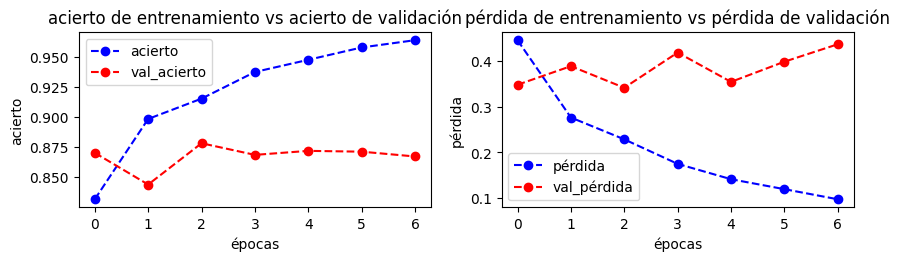

In [35]:
print("VGG16")
plot_acierto_perdida(history_VGG16)
print("\n")

ResNet50


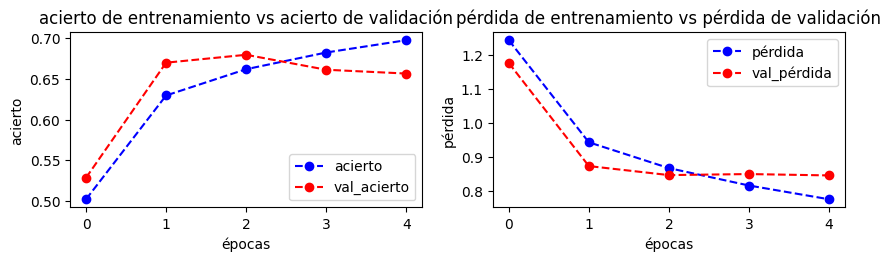

In [36]:
print("ResNet50")
plot_acierto_perdida(history_ResNet50)
print("\n")

InceptionV3


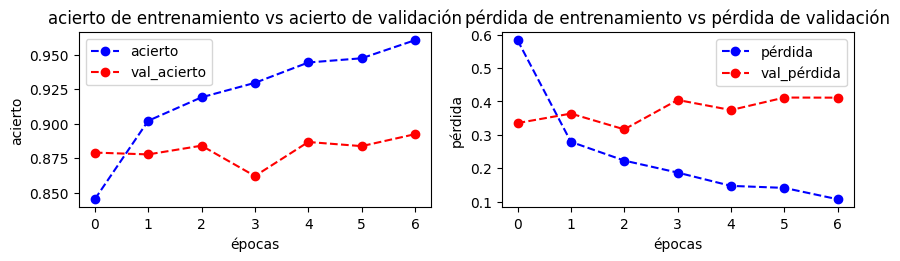

In [37]:
print("InceptionV3")
plot_acierto_perdida(history_InceptionV3)
print("\n")

In [31]:
# Evaluar los modelos
print("Evaluacion VGG16")
test_loss_VGG16, test_acc_VGG16 = model_VGG16.evaluate(test_images, test_labels)
print("\n")

Evaluacion VGG16
94/94 ━━━━━━━━━━━━━━━━━━━━ 41s 439ms/step - accuracy: 0.8931 - loss: 0.3214




In [32]:
print("Evaluacion ResNet50")
test_loss_ResNet50, test_acc_ResNet50 = model_ResNet50.evaluate(
    test_images, test_labels
)
print("\n")

Evaluacion ResNet50
94/94 ━━━━━━━━━━━━━━━━━━━━ 21s 224ms/step - accuracy: 0.5115 - loss: 1.1870




In [33]:
print("Evaluacion InceptionV3")
test_loss_InceptionV3, test_acc_InceptionV3 = model_InceptionV3.evaluate(
    test_images, test_labels
)
print("\n")

Evaluacion InceptionV3
94/94 ━━━━━━━━━━━━━━━━━━━━ 10s 108ms/step - accuracy: 0.8742 - loss: 0.3585




El mejor modelo es el modelo VGG16, ya que tiene la mejor precisión en el conjunto de validación. En la epoca 5 obtiene una precisión de 0.89 y una perdida de 0.32. Por lo tanto, se usará este modelo para predecir las imagenes de test.

# B.5. Predecir las imagenes de test

94/94 ━━━━━━━━━━━━━━━━━━━━ 41s 432ms/step


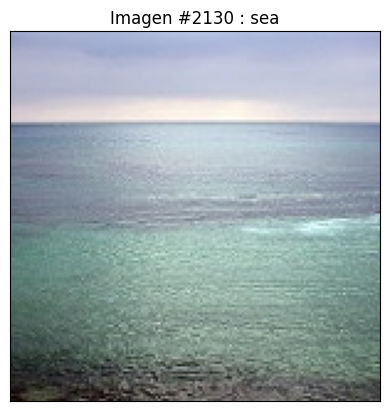

In [38]:
predictions = model_VGG16.predict(test_images)  # Vector of probabilities
pred_labels = np.argmax(predictions, axis=1)  # We take the highest probability

mostrar_imagen_aleatoria(nombres_clases, test_images, pred_labels)

# B.6 Analisis del Error

Vamos a ver algunas de las imágenes mal etiquetadas.

In [39]:
def print_mislabeled_images(nombres_clases, test_images, test_labels, pred_labels):
    """
    Imprime 25 ejemplos de imágenes mal etiquetadas por el clasificador, es decir, cuando test_labels != pred_labels
    """
    BOO = test_labels == pred_labels
    mislabeled_indices = np.where(BOO == 0)
    mislabeled_images = test_images[mislabeled_indices]
    mislabeled_labels = pred_labels[mislabeled_indices]

    titulo = "Algunos ejemplos de imágenes mal etiquetadas por el clasificador:"
    print(titulo)
    mostrar_ejemplos(nombres_clases, mislabeled_images, mislabeled_labels)

Algunos ejemplos de imágenes mal etiquetadas por el clasificador:


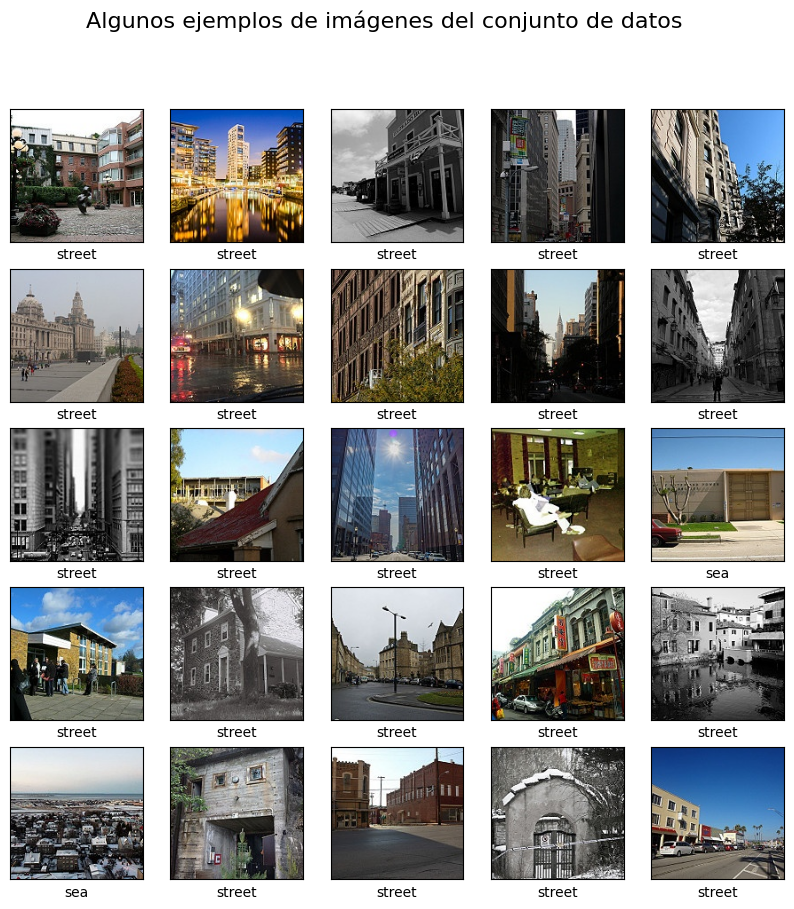

In [40]:
print_mislabeled_images(nombres_clases, test_images, test_labels, pred_labels)

# B.7. Matriz de Confusión

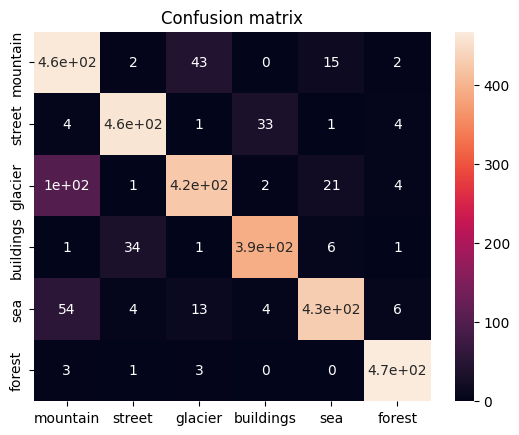

In [41]:
CM = confusion_matrix(test_labels, pred_labels)
ax = plt.axes()
sn.heatmap(
    CM,
    annot=True,
    annot_kws={"size": 10},
    xticklabels=nombres_clases,
    yticklabels=nombres_clases,
    ax=ax,
)
ax.set_title("Confusion matrix")
plt.show()

In [42]:
CM

array([[463,   2,  43,   0,  15,   2],
       [  4, 458,   1,  33,   1,   4],
       [101,   1, 424,   2,  21,   4],
       [  1,  34,   1, 394,   6,   1],
       [ 54,   4,  13,   4, 429,   6],
       [  3,   1,   3,   0,   0, 467]], dtype=int64)

# C. Conclusiones Matriz de Confusión

## Errores Comunes:
- **‘Street’ y ‘Buildings’**: Hay una confusión significativa con 33 imágenes de ‘Street’ clasificadas incorrectamente como ‘Buildings’.
- **‘Glacier’ y ‘Mountain’**: 101 imágenes de ‘Glacier’ clasificadas incorrectamente como ‘Mountain’. Lo cual es entendible ya que los glaciares tienen formas muy similares a las montañas.
- **‘Sea’ y ‘Mountain’**: 54 imágenes de ‘Sea’ clasificadas incorrectamente como ‘Mountain’.

## Categorías con Mejor Rendimiento:
- **‘Forest’**: Tiene el mejor rendimiento al tener pocos errores.

## Categorías con Peor Rendimiento:
- **‘Street’**: Tiene un número considerable de errores, especialmente con ‘Buildings’.
- **‘Glacier’**: Muestra confusiones notables con ‘Mountain’ y ‘Sea’.


# D. Comparación VGG16 con CNN manualmente entrenada

## Conclusiones Finales

- **Precisión General**: Ambos modelos muestran una buena precisión general, pero la red CNN manualmente entrenada parece tener un rendimiento ligeramente mejor en algunas categorías como ‘Forest’ y ‘Street’.
- **Errores Comunes**: La red CNN manualmente entrenada tiene más errores en la clasificación de ‘Mountain’ y ‘Glacier’ en comparación con VGG16.
- **Categorías con Mejor Rendimiento**: ‘Forest’ tiene el mejor rendimiento en ambos modelos, pero la red CNN manualmente entrenada tiene un número ligeramente mayor de predicciones correctas.
- **Categorías con Peor Rendimiento**: ‘Mountain’ y ‘Glacier’ presentan más errores en la red CNN manualmente entrenada en comparación con VGG16.
